In [45]:
import yaml 
import pandas as pd
from collections import defaultdict
import glob
import xgboost as xg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
import pickle
pd.set_option("display.max_columns", None)

In [47]:
stats = glob.glob("data/*.csv")
df = pd.DataFrame()
for year in stats:
    year_data = pd.read_csv(year, sep=',', header=0)
    df = df.append(year_data, sort=True)

df = df.fillna(0)
current_season_weeks = df[df['season']==2021]['week'].max()

In [3]:
with open("scoring.yaml", "r") as stream:
    try:
        scoring_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [4]:
def calculate_points(row, yaml_dict):
    points = 0.0
    
    # PASSING
    points += float(row['passing_yards']) * yaml_dict['OFFENSE']['PASSING']['PASSING_YARDS']
    points += float(row['passing_tds']) * yaml_dict['OFFENSE']['PASSING']['PASSING_TDS']
    points += float(row['interceptions']) * yaml_dict['OFFENSE']['PASSING']['INT']
    points += float(row['passing_2pt_conversions']) * yaml_dict['OFFENSE']['PASSING']['2_PT_PASS_CONVERSION']
    
    # RUSHING
    points += float(row['rushing_yards']) * yaml_dict["OFFENSE"]["RUSHING"]['RUSHING_YARDS']
    points += float(row['rushing_tds']) * yaml_dict["OFFENSE"]["RUSHING"]["RUSHING_TD"]
    points += float(row['rushing_2pt_conversions']) * yaml_dict["OFFENSE"]["RUSHING"]["2_PT_RUSH_CONVERSION"]
    
    # Receiving
    points += float(row['receiving_yards']) * yaml_dict["OFFENSE"]["RECEIVING"]['RECEIVING_YARDS']
    points += float(row['receptions']) * yaml_dict['OFFENSE']['RECEIVING']['RECEPTION']
    points += float(row['receiving_tds']) * yaml_dict["OFFENSE"]["RECEIVING"]['RECEPTION_TD']
    points += float(row['receiving_2pt_conversions']) * yaml_dict['OFFENSE']['RECEIVING']['2_PT_RECEIVING_CONVERSION']
    
    # MISC
    points += float(row['special_teams_tds']) * yaml_dict["OFFENSE"]["MISC"]['KICKOFF_RETURN']
    
    return points

In [5]:
df['calculated_fantasy_points'] = df.apply(lambda x: calculate_points(x, scoring_dict), axis=1)

In [18]:
week_count_per_season = df.groupby(['player_id', 'season'])['week'].count().to_frame().reset_index()
weekly_count_dict = defaultdict(dict)
for idx, row in week_count_per_season.iterrows():
    weekly_count_dict[row['player_id']][row['season']] = row['week']



In [20]:
# Add next years avg fantasy points to current year. 
sum_per_year = defaultdict(lambda: defaultdict(float))

for idx, row in df.iterrows():
    sum_per_year[row['player_id']][row['season']] += row['calculated_fantasy_points']

avg_per_year = defaultdict(lambda: defaultdict(float))
for player_id, season_to_calc_fp in sum_per_year.items():
    for season, fp in season_to_calc_fp.items():
        avg_per_year[player_id][season] = fp / (weekly_count_dict[player_id][season])
        
        
    
        

In [21]:
# Remove columns that we aren't interested in. 
df.drop(['dakota', 'fantasy_points', 'fantasy_points_ppr', 'pacr', 'passing_epa', 'racr', 
             'receiving_epa', 'rushing_epa', 'calculated_fantasy_points', 'wopr', 'week'], axis=1, inplace=True)

player_name_mapping = dict(zip(df['player_id'], df['player_name']))

In [22]:
df['player_name'] = df['player_id'].map(player_name_mapping)

In [23]:
df = df.groupby(['player_id', 'player_name', 'season']).sum()
df = df.reset_index(level=['player_id', 'player_name', 'season'])
df['next_years_avg_points'] = df.apply(lambda x: avg_per_year[x['player_id']][x['season'] + 1], axis=1)

In [24]:
# split data into inputs and target
up_to_nineteen = df[df['season'] <= 2019]
up_to_nineteen = up_to_nineteen.set_index('player_id')
up_to_nineteen = up_to_nineteen.drop('player_name', axis=1)
inputs = up_to_nineteen.loc[:, up_to_nineteen.columns != 'next_years_avg_points']
target = up_to_nineteen['next_years_avg_points']

# Get train and test data 
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=123)

In [25]:
model = xg.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xg_reg = xg.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

xgb_preds = xg_reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, xgb_preds))
print(rmse)

4.704435453640215


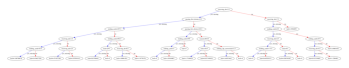

In [26]:
xg.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 50]
plt.savefig('test.branching.jpg')

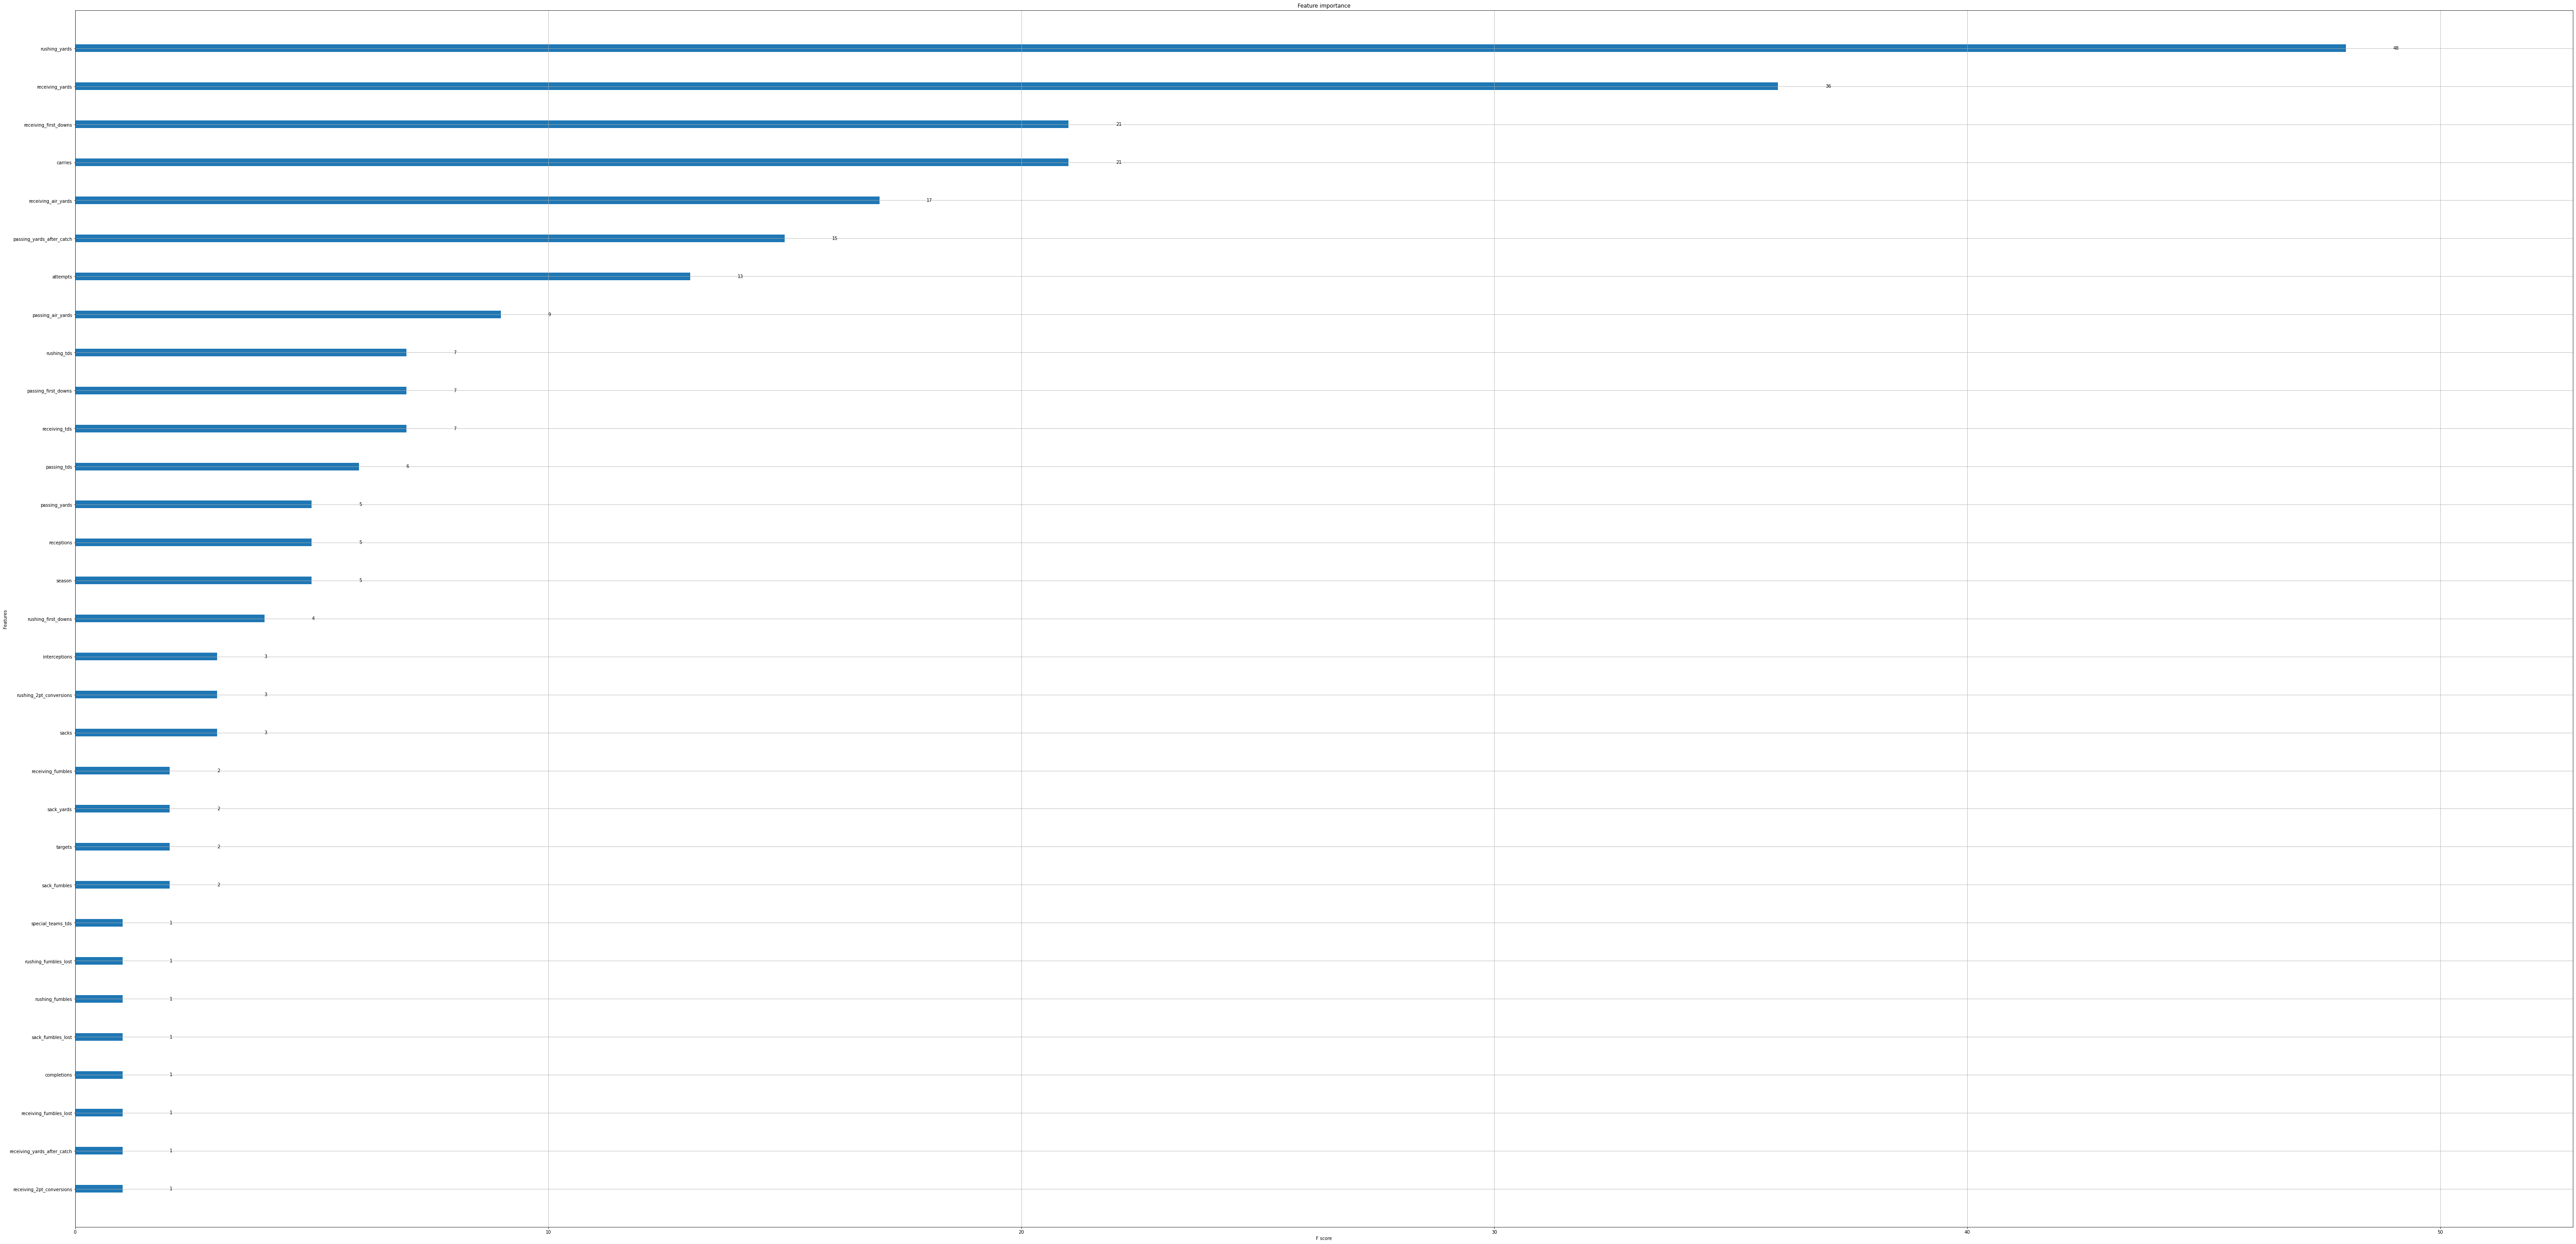

In [13]:
xg.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

RMSE: 3.863256


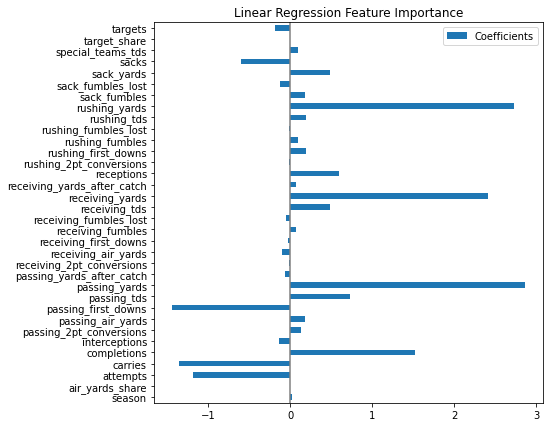

In [30]:
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lm_reg = make_pipeline(StandardScaler(), LinearRegression())
lm_reg = lm_reg.fit(X_train, y_train)

lm_preds = lm_reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, lm_preds))
print("RMSE: %f" % (rmse))

coefs = pd.DataFrame(
   lm_reg[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Regression Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


RMSE: 4.330645


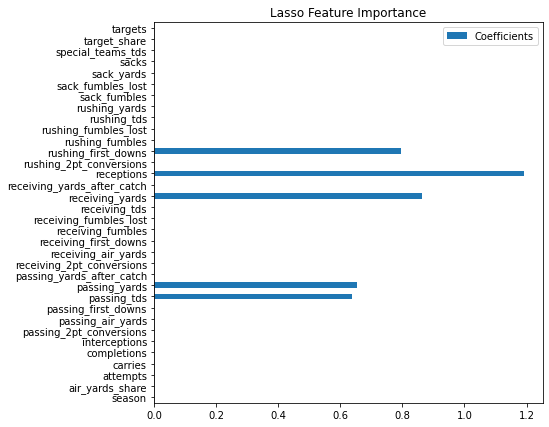

In [31]:
lasso_reg = make_pipeline(StandardScaler(), Lasso())
lasso_reg = lasso_reg.fit(X_train, y_train)

lasso_preds = lasso_reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, lasso_preds))
print("RMSE: %f" % (rmse))

coefs = pd.DataFrame(
   lasso_reg[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Lasso Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

RMSE: 3.858674


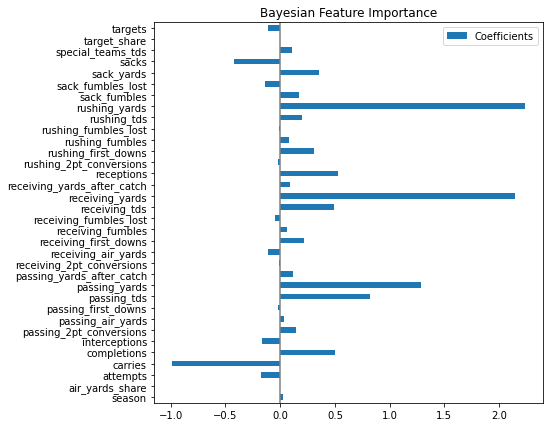

In [32]:
bayes_model = make_pipeline(StandardScaler(), BayesianRidge())
bayes_model = bayes_model.fit(X_train, y_train)

bayes_preds = bayes_model.predict(X_test)
rmse = np.sqrt(MSE(y_test, bayes_preds))
print("RMSE: %f" % (rmse))

coefs = pd.DataFrame(
   bayes_model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Bayesian Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

RMSE: 4.101983


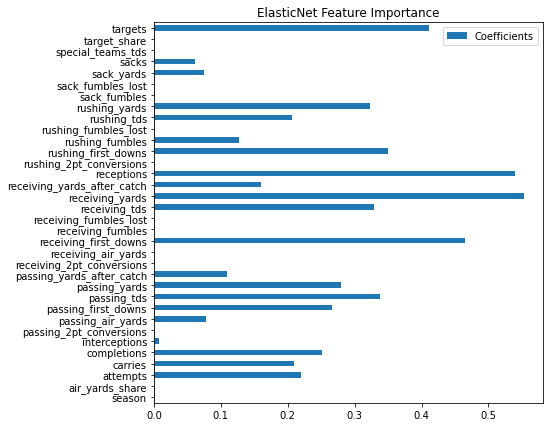

In [33]:
enet_model = make_pipeline(StandardScaler(), ElasticNet())
enet_model = enet_model.fit(X_train, y_train)

enet_preds = enet_model.predict(X_test)
rmse = np.sqrt(MSE(y_test, enet_preds))
print("RMSE: %f" % (rmse))

coefs = pd.DataFrame(
   enet_model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('ElasticNet Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [42]:
from sklearn.inspection import permutation_importance
params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_split': 5,
    'learning_rate': 0.01,
    'loss': 'squared_error',
}

gbr_model = make_pipeline(StandardScaler(), GradientBoostingRegressor(**params))

gbr_model = gbr_model.fit(X_train, y_train)

gbr_preds = gbr_model.predict(X_test)
rmse = np.sqrt(MSE(y_test, gbr_preds))
print("RMSE: %f" % (rmse))


RMSE: 3.884217


In [43]:
# Use 2020 player stats to predict who will be good in 2021
twenty_twenty = df[df['season']==2020]
twenty_twenty = twenty_twenty.set_index('player_id')
twenty_twenty = twenty_twenty.drop('player_name', axis=1)

inputs = twenty_twenty.loc[:, twenty_twenty.columns != 'next_years_avg_points']
xg_preds = xg_reg.predict(inputs)
lr_preds = lm_reg.predict(inputs)
lasso_preds = lasso_reg.predict(inputs)
bayes_preds = bayes_model.predict(inputs)
enet_preds = enet_model.predict(inputs)
gbr_preds = gbr_model.predict(inputs)

In [44]:
twenty_twenty['xg_preds'] = xg_preds
twenty_twenty['linear_preds'] = lr_preds
twenty_twenty['lasso_preds'] = lasso_preds
twenty_twenty['bayes_preds'] = bayes_preds
twenty_twenty['enet_preds'] = enet_preds
twenty_twenty['gbr_preds'] = gbr_preds
twenty_twenty['player_name'] = twenty_twenty.index.map(player_name_mapping)
twenty_twenty.sort_values(by="bayes_preds", ascending=False)

,season,air_yards_share,attempts,carries,completions,interceptions,passing_2pt_conversions,passing_air_yards,passing_first_downs,passing_tds,passing_yards,passing_yards_after_catch,receiving_2pt_conversions,receiving_air_yards,receiving_first_downs,receiving_fumbles,receiving_fumbles_lost,receiving_tds,receiving_yards,receiving_yards_after_catch,receptions,rushing_2pt_conversions,rushing_first_downs,rushing_fumbles,rushing_fumbles_lost,rushing_tds,rushing_yards,sack_fumbles,sack_fumbles_lost,sack_yards,sacks,special_teams_tds,target_share,targets,next_years_avg_points,xg_preds,linear_preds,lasso_preds,bayes_preds,enet_preds,gbr_preds,player_name
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00-0034857,2020,0.0,692,127,473,11,0,5939,272,42,5361,2166,0,-5,1,0,0,1,12,17,1,0,45,4,4,9,566,7,2,253,34,0,0.0,1,26.825714,12.430486,25.164861,15.245820,25.043451,17.891499,21.715136,J.Allen
00-0033873,2020,0.0,705,75,466,8,3,5682,281,42,5590,2705,0,25,0,0,0,0,0,0,0,0,26,2,0,3,360,4,2,174,26,0,0.0,2,22.452500,11.666151,23.915841,14.215452,24.291527,16.060312,20.848531,P.Mahomes
00-0023459,2020,0.0,610,42,428,6,0,4800,250,53,4941,2575,0,-4,0,0,0,0,-6,-2,1,0,16,3,1,4,146,1,1,214,25,0,0.0,1,19.382500,11.147030,21.811265,14.467822,22.209488,15.503684,14.086066,A.Rodgers
00-0034796,2020,0.0,424,184,273,11,1,3624,150,26,3098,1299,0,0,0,0,0,0,0,0,0,0,63,6,2,8,1175,5,2,198,37,0,0.0,0,24.531429,6.198417,22.075944,12.467895,21.664508,14.735116,16.543091,L.Jackson
00-0029263,2020,0.0,585,87,395,14,1,5201,218,42,4386,1867,0,0,0,0,0,0,0,0,0,0,27,4,2,2,563,2,2,333,52,0,0.0,0,19.728000,11.666151,21.746311,13.305461,21.539322,15.275794,20.126716,R.Wilson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00-0036000,2020,0.0,0,1,0,0,0,0,0,0,0,0,0,-4,0,0,0,0,2,6,1,0,0,0,0,0,-12,0,0,0,0,0,0.0,1,0.000000,1.710140,1.603607,3.102683,1.617364,2.649762,1.430468,A.Killins
00-0022787,2020,0.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4,0,0,0,0,0,0.0,0,0.000000,1.995380,1.602508,3.048603,1.614563,2.621823,2.539686,M.Schaub
00-0035864,2020,0.0,9,2,1,2,0,134,1,0,13,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,1,1,0,0.0,0,5.500000,2.281450,1.548624,3.059073,1.600677,2.696934,3.079126,K.Hinton
